In [ ]:
!pip uninstall torch
!pip install torch
!pip install matplotlib
!pip install seaborn
!pip install pillow

Found existing installation: torch 1.12.1+cu113
Uninstalling torch-1.12.1+cu113:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.12.1+cu113.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
    /usr/local/lib/python3.7/dist-packages/torchgen/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:48tcmalloc: large alloc 1147494400 bytes == 0x667ae000 @  0x7f8066bdd615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchvision
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

import copy

from IPython.display import clear_output
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.7/dist-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
TRAIN, TEST, VAL = 'train', 'test', 'val'

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 0.001

In [ ]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(234),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(234),
        transforms.ToTensor(),
    ]),
}

In [ ]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/data.zip', 'r') as zObject:
    zObject.extractall()

dataset = datasets.ImageFolder('data', transform=data_transforms[TRAIN])

train_dataset, test_dataset, val_dataset = random_split(dataset, [0.76, 0.2, 0.04], generator=torch.Generator().manual_seed(SEED))

In [ ]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = len(train_dataset)

In [ ]:
train_dl = DataLoader(train_dataset, TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
test_dl = DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, VAL_BATCH_SIZE, shuffle=True, num_workers=2)

datasets = {
    TRAIN: train_dataset, 
    TEST: test_dataset, 
    VAL: val_dataset
}

dataloaders = {
    TRAIN: train_dl, 
    TEST: test_dl, 
    VAL: val_dl
}

dataset_sizes = {x: len(datasets[x]) for x in [TRAIN, TEST, VAL]}

In [ ]:
dataset.find_classes('data')[1]

{'breakcore': 0, 'draincore': 1, 'glitchcore': 2, 'weirdcore': 3}

In [ ]:
class_options = {v: k for k, v in dataset.find_classes('data')[1].items()}

def class_proportion(data, options=class_options):
    classes = list(map(lambda x: options[x[1]], data))
    plt.hist(classes)

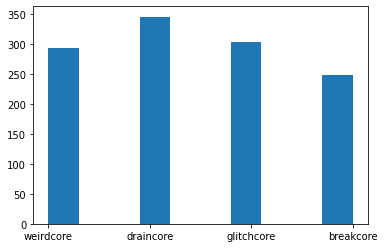

In [ ]:
class_proportion(datasets[TRAIN])

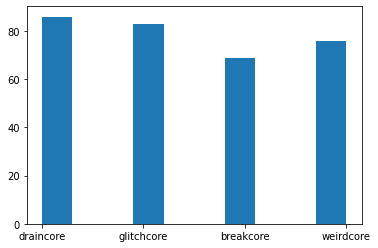

In [ ]:
class_proportion(datasets[TEST])

In [ ]:
def preview_img(img_tensor, label_idx=None, index2class=class_options):
    plt.imshow(img_tensor.permute(1, 2, 0))
    if label_idx is not None:
        if torch.is_tensor(label_idx):
            label_idx = label_idx.item()
        try:
            print(index2class[label_idx])
        except KeyError:
            pass

weirdcore


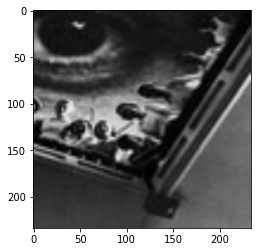

In [ ]:
idx = 7
preview_img(images[idx], labels[idx])

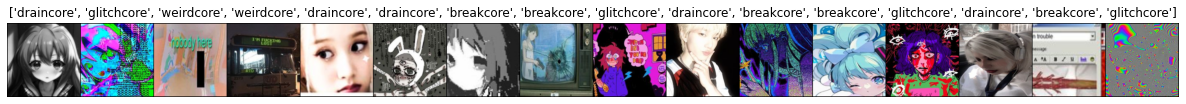

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(21, 21))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs, nrow=len(inputs))
    imshow(out, title=[class_options[x.item()] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TRAIN]):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        size = inputs.size()[0]
        
        with torch.no_grad():
            outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.eval()

        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
            
        with torch.no_grad():
            outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
# Generally unsafe, but might save a lot of time
# You might want to load your model without this
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(models.VGG16_BN_Weights.DEFAULT)
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_options))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
vgg16 = vgg16.to(DEVICE)
print(vgg16)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=LR, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.05)

In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 19/20
Evaluation completed in 0m 3s
Avg loss (test): 0.0911
Avg acc (test): 0.2325
----------


Ground truth:


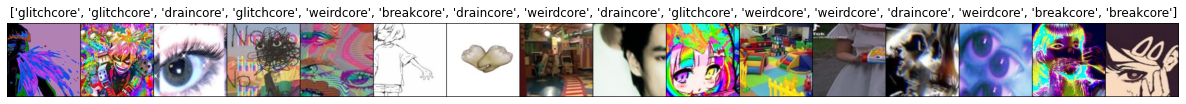

Prediction:


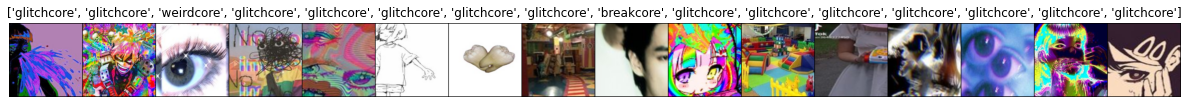

In [ ]:
visualize_model(vgg16)

In [ ]:
from collections import defaultdict


def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0

    metrics = defaultdict(list)
    
    batches = {
        TRAIN: len(dataloaders[TRAIN]), 
        VAL: len(dataloaders[VAL])
    }

    
    for epoch in tqdm(range(num_epochs)):
        metrics['Epoch'].append(epoch)

        for stage in [TRAIN, VAL]:
          vgg.train(stage == TRAIN)

          loss_epoch = 0
          acc_epoch = 0
          
          with torch.set_grad_enabled(stage == TRAIN):
            for i, data in enumerate(dataloaders[stage]):
                print("\r Batch {}/{}".format(i, batches[stage]), end='', flush=True)
                    
                inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = vgg(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if stage == TRAIN:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                loss_epoch += loss.data.item()
                acc_epoch += torch.sum(preds == labels.data).item()
                
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

          if stage == TRAIN:
              scheduler.step()
          
          avg_loss = loss_epoch / dataset_sizes[stage]
          avg_acc = acc_epoch / dataset_sizes[stage]

          if stage == VAL:
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_model_wts = copy.deepcopy(vgg.state_dict())
          
          metrics[f'{stage.title()} loss'].append(avg_loss)
          metrics[f'{stage.title()} acc'].append(avg_acc)

        clear_output(wait=True)
        display(pd.DataFrame(metrics))

        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10);

,Epoch,Train loss,Train acc,Val loss,Val acc
0,0,0.058145,0.624161,0.010806,0.790323
1,1,0.039428,0.759228,0.010396,0.806452
2,2,0.034728,0.787752,0.010869,0.790323
3,3,0.033088,0.798658,0.010961,0.693548
4,4,0.027193,0.845638,0.010059,0.709677
5,5,0.023967,0.863255,0.011137,0.822581
6,6,0.023316,0.854866,0.011215,0.709677
7,7,0.019004,0.889262,0.008920,0.741935
8,8,0.017430,0.906879,0.011074,0.822581
9,9,0.018593,0.894295,0.009075,0.806452


100%|██████████| 10/10 [04:44<00:00, 28.44s/it]


Training completed in 4m 44s
Best acc: 0.8226


In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 19/20
Evaluation completed in 0m 3s
Avg loss (test): 0.0441
Avg acc (test): 0.7580
----------


Ground truth:


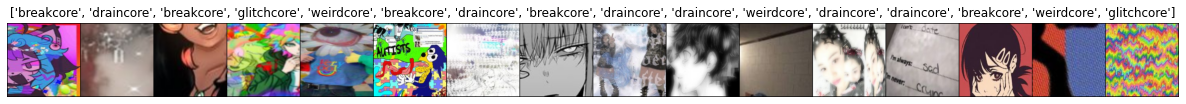

Prediction:


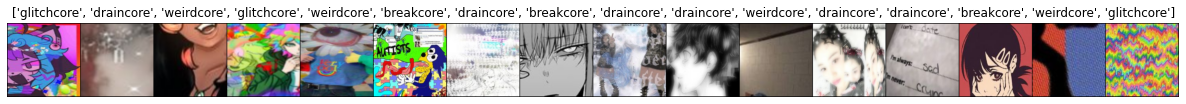

In [ ]:
visualize_model(vgg16)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion(model, index_class_map=class_options):
    y_true, y_pred = [], []

    model.eval()

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
            
        with torch.no_grad():
            outputs = model(inputs).cpu().data.numpy().argmax(axis=1)
        y_pred.extend(outputs)

        labels = labels.data.numpy()
        y_true.extend(labels)
        
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix,
                         index = list(index_class_map.values()),
                         columns = list(index_class_map.values()))
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues').set(xlabel='Predicted Label', ylabel='True Label')

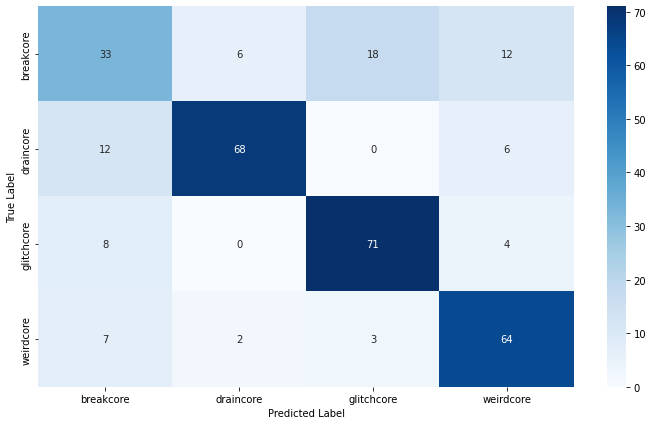

In [ ]:
plot_confusion(vgg16)

In [ ]:
# Run to save uptrained model weights
import os

MODEL_PATH = os.path.join(os.getcwd(), 'model_state_dict')
torch.save(vgg16.state_dict(), MODEL_PATH)

Play Ground

In [ ]:
from PIL import Image
import os

def which_core_are_you(model, img_filename, index_class_map=class_options):
    model.eval()

    # img_name = os.path.splitext(img_filename.split('/')[-1])[0]
    img_name = img_filename.split('/')[-1]
    img = Image.open(f'playground/{img_name}')
    img_tensor = data_transforms[VAL](img).unsqueeze(dim=0).to(DEVICE)

    with torch.no_grad():
        result = model(img_tensor).cpu().data.numpy().argmax()
    preview_img(img_tensor.cpu().squeeze(dim=0), result)

draincore


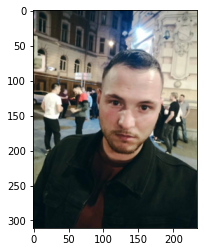

In [ ]:
which_core_are_you(vgg16, '/content/playground/2022-11-19 13.48.16.jpg')